In [81]:
import numpy as np
import torch
import os
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
print('Pytorch version:[%s].'%(torch.__version__))

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('[%s].'%(device))

Pytorch version:[1.13.0].
[cuda:0].


## Set hyper parameter

In [95]:
EPOCHS = 2
BATCH_SIZE = 256
LEARNING_RATE = 0.001

## Prepare dataset

In [83]:
train_transforms = transforms.Compose([#transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       #transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])
                                     ])


test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])
                                     ])


DATASET_PATH = './data/dataset/'
train_data = datasets.ImageFolder(DATASET_PATH + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(DATASET_PATH + '/test', transform=test_transforms)

train_iter = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=20)
test_iter = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=20)

print('preparing dataset Done')

preparing dataset Done


our model

In [96]:
class Model(nn.Module):
    def __init__(self, input_size = [3,224,224], # rgb, input_size
                 hidden_size = [32, 64], # 은닉층 노드 수
                 num_classes=119, init_weight='he', init_bias = 'zero'):
        super(Model, self).__init__()

        self.init_weight = init_weight
        self.init_bias = init_bias

        layer_list = []
        prev_channel = input_size[0]

        for idx in range(len(hidden_size)):
            layer_list.append(nn.Conv2d(prev_channel, hidden_size[idx], kernel_size=3, stride=1, padding=1))
            layer_list.append(nn.BatchNorm2d(hidden_size[idx]))
            layer_list.append(nn.ReLU(True))
            layer_list.append(nn.MaxPool2d(kernel_size=2, stride=2))
            prev_channel = hidden_size[idx]
        
        layer_list.append(nn.Flatten())
        feature_size = int(input_size[1]/ 2**len(hidden_size))
        layer_list.append(nn.Linear(feature_size*feature_size * prev_channel, 119))

        self.net = nn.Sequential(*layer_list)

        self.init_params()

    def init_params(self):
        init_weight_method = {
            'he' : nn.init.kaiming_normal_,
            'xavier' : nn.init.xavier_normal_
        }
        assert self.init_weight in init_weight_method.keys(), f'Select the weight initialization method in {list(init_weight_method.keys())}'

        init_bias_method = {
            'zero' : nn.init.zeros_,
            'uniform' : nn.init.uniform_
        }
        assert self.init_bias in init_bias_method.keys(), f'Select the bias initialization method in {list(init_bias_method.keys())}'


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init_weight_method[self.init_weight](m.weight)
                init_bias_method[self.init_bias](m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, X):
        return self.net(X)
        

In [85]:
model = Model(hidden_size=[64,32,64]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [86]:
total_params = 0
for param_name, param in model.named_parameters():
    if param.requires_grad:
        total_params += len(param.reshape(-1))
print(f'Number of Total Parameters: {total_params: ,d}')

Number of Total Parameters:  6,010,135


In [91]:
def test_eval(model, data_iter, batch_size):
    with torch.no_grad():
        test_loss = 0
        total = 0
        correct = 0
        model.eval()
        for batch_img, batch_lab in data_iter:
            X = batch_img.view(-1, 3, 224, 224).to(device)
            Y = batch_lab.to(device)
            y_pred = model(X)
            _, predicted = torch.max(y_pred.data, 1)
            correct += (predicted == Y).sum().item()
            total += batch_img.size(0)
        val_acc = (100 * correct / total)
        model.train()
    return val_acc

In [97]:
# traning phase
print_every = 1
best_accuracy = 0
print('Start training !')
checkpoint_dir = 'weight'

if os.path.exists(checkpoint_dir) and len(os.listdir(checkpoint_dir)) != 0:
    model = torch.load(f'{checkpoint_dir}/model.pt')
    model.load_state_dict(
        torch.load(f'{checkpoint_dir}/model_state_dict.pt')
    )
    checkpoint = torch.load(f'{checkpoint_dir}/all.tar')
    # model.load_state_dict(checkpoint['model])
    optimizer.load_state_dict(checkpoint['optimizer'])

else:
    model = Model(hidden_size=[64, 32, 64]).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)


# Training loop
for epoch in range(EPOCHS):
    loss_val_sum = 0
    for batch_img, batch_lab in train_iter:
        X = batch_img.view(-1, 3, 224, 224).to(device)
        Y = batch_lab.to(device)

        # Inference & Calculate loss
        y_pred = model.forward(X)
        loss = criterion(y_pred, Y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_val_sum += loss

        if ((epoch%print_every) == 0) or (epoch == (EPOCHS -1 )):
            # accr_val = M.test(x_test, y_test, batch_size)
            loss_val_avg = loss_val_sum / len(train_iter)
            accr_val = test_eval(model, test_iter, BATCH_SIZE)
             
            print(f'epoch:[{epoch+1}/{EPOCHS}] cost:[{loss_val_avg:.3f}] test_accuracyL:[{accr_val:.3f}]')

        if accr_val > best_accuracy:
            best_accuracy = accr_val
            if not os.path.exists(checkpoint_dir):
                os.mkdir(checkpoint_dir)
            print(f'Model Saved : acc - {accr_val}')

            torch.save(model, f'{checkpoint_dir}/model.pt')
            torch.save(model.state_dict(), 
                   f'{checkpoint_dir}/model_state_dict.pt')  
            torch.save({
                'model' : model.state_dict(),
                'optimizer' : optimizer.state_dict()   
                      }, f'{checkpoint_dir}/all.tar')
    if abs(accr_val - best_accuracy) < 0.05:
        print('accr_val is same --- stop iterate')
        break
print('Training Done !')
        

Start training !
epoch:[1/1] cost:[0.005] test_accuracyL:[2.332]
Model Saved : acc - 2.3323615160349855
epoch:[1/1] cost:[0.010] test_accuracyL:[2.274]
epoch:[1/1] cost:[0.015] test_accuracyL:[2.235]
epoch:[1/1] cost:[0.020] test_accuracyL:[2.255]
epoch:[1/1] cost:[0.025] test_accuracyL:[2.177]
epoch:[1/1] cost:[0.030] test_accuracyL:[2.177]
epoch:[1/1] cost:[0.034] test_accuracyL:[2.293]
epoch:[1/1] cost:[0.039] test_accuracyL:[2.332]
epoch:[1/1] cost:[0.044] test_accuracyL:[2.177]
epoch:[1/1] cost:[0.049] test_accuracyL:[2.119]
epoch:[1/1] cost:[0.054] test_accuracyL:[2.138]
epoch:[1/1] cost:[0.059] test_accuracyL:[2.099]
epoch:[1/1] cost:[0.064] test_accuracyL:[2.157]
epoch:[1/1] cost:[0.069] test_accuracyL:[2.099]
epoch:[1/1] cost:[0.074] test_accuracyL:[2.099]
epoch:[1/1] cost:[0.078] test_accuracyL:[2.119]
epoch:[1/1] cost:[0.084] test_accuracyL:[1.983]
epoch:[1/1] cost:[0.088] test_accuracyL:[2.138]
epoch:[1/1] cost:[0.093] test_accuracyL:[2.099]
epoch:[1/1] cost:[0.098] test_ac

In [105]:
# test_iter = torch.utils.data.DataLoader(test_data, batch_size = BATCH_SIZE, shuffle=True, num_workers=1)
data_iter = iter(test_iter)
images, labels = next(data_iter)

In [106]:
labels

tensor([ 93,  60,  78,  65,  62,   3,  45,  37,  85, 107,  70, 110,  48,  80,
          6,  70])

In [107]:
def imshow(image, ax = None, title = None, normalize = True):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1,2,0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    # ax.thick_params(axis = 'both', length = 0)
    ax.set_title(title)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

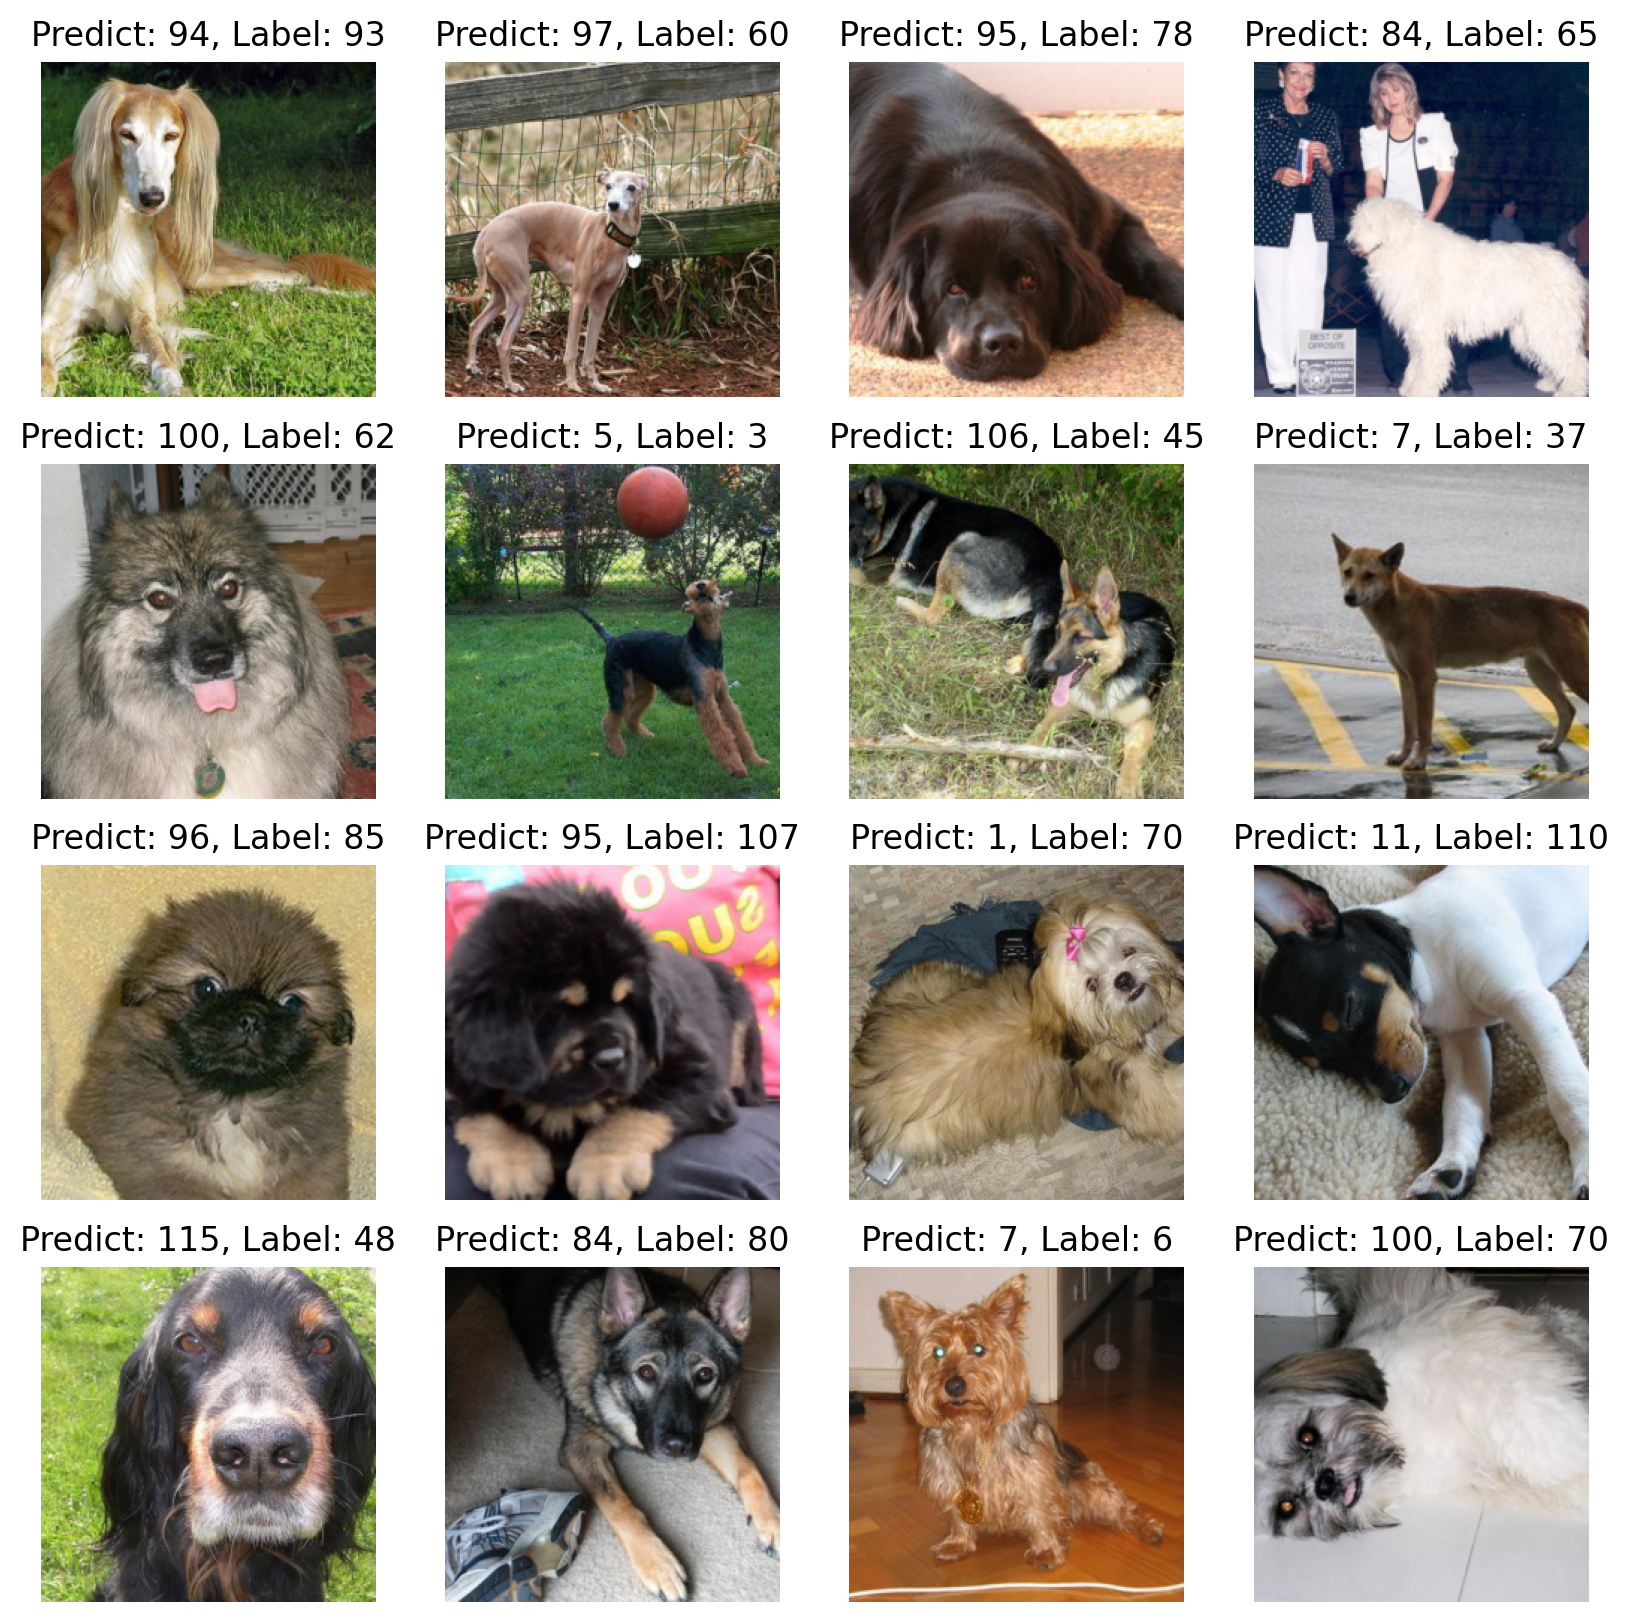

In [108]:
n_sample = 16
# sample_indices = np.random.choice(len())
test_x = images[:n_sample]
test_y = labels[:n_sample]

with torch.no_grad():
    model.eval()
    y_pred = model.forward(test_x.view(-1, 3, 224, 224).type(torch.float).to(device))
    model.train()

y_pred = y_pred.argmax(axis = 1)

plt.figure(figsize=(10, 10))


for idx in range(n_sample):
    ax = plt.subplot(4,4, idx+1)
    title = f'Predict: {y_pred[idx]}, Label: {test_y[idx]}'
    imshow(test_x[idx], ax, title)
    plt.subplot(4, 4, idx+1)
    # plt.imshow(test_x[idx].numpy().transpose((1,2,0)))
    plt.axis('off')
    plt.title(f"Predict: {y_pred[idx]}, Label: {test_y[idx]}")
plt.show()

In [71]:
model.forward(test_x.view(-1, 3, 224, 224).type(torch.float).to(device))

tensor([[-0.1214,  0.2575, -0.0362,  ..., -0.0281,  0.0430, -0.0591],
        [-0.1214,  0.2575, -0.0362,  ..., -0.0281,  0.0430, -0.0591],
        [-0.1214,  0.2575, -0.0362,  ..., -0.0281,  0.0430, -0.0591],
        ...,
        [-0.1214,  0.2575, -0.0362,  ..., -0.0281,  0.0430, -0.0591],
        [-0.1214,  0.2575, -0.0362,  ..., -0.0281,  0.0430, -0.0591],
        [-0.1214,  0.2575, -0.0362,  ..., -0.0281,  0.0430, -0.0591]],
       device='cuda:0', grad_fn=<AddmmBackward0>)